In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epochs = 10
image_size = (32, 32) # h x w
batch_size = 32

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train_splitted, x_val, y_train_splitted, y_val =\
    train_test_split(x_train, y_train, test_size=0.1, random_state=42)

x_train_splitted = (x_train_splitted - 127.5) / 127.5 #Normalizing
x_val = (x_val - 127.5) / 127.5 #Normalizing
x_test = (x_test - 127.5) / 127.5 #Normalizing

dataset_train = tf.data.Dataset.from_tensor_slices(
    (x_train_splitted, tf.reshape(tf.one_hot(y_train_splitted, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

dataset_validation = tf.data.Dataset.from_tensor_slices(
    (x_val, tf.reshape(tf.one_hot(y_val, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices(
    (x_test, tf.reshape(tf.one_hot(y_test, 10), (-1, 10)))
).batch(batch_size, drop_remainder=True)

170508288/170498071 [==============================] - 3s 0us/step


2022-05-01 13:41:46.081232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 13:41:46.191453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 13:41:46.192295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 13:41:46.194681: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
inception_model = keras.applications.inception_v3.InceptionV3(
    input_shape=(299, 299, 3),
    weights='imagenet',
    include_top=False
)

87924736/87910968 [==============================] - 0s 0us/step


In [5]:
image_batch, label_batch = next(iter(dataset_train))
print(image_batch.shape, label_batch.shape)
resized = tf.image.resize(image_batch, [299, 299], preserve_aspect_ratio=True, method='nearest')

feature_batch = inception_model(resized)
print(feature_batch.shape)
# (32, 8, 8, 2048) kimenete lesz a képeknek

2022-05-01 13:41:54.601723: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.
2022-05-01 13:41:55.263119: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


(32, 32, 32, 3) (32, 10)


2022-05-01 13:41:56.004982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 8, 8, 2048)


In [6]:
# Freezing the base model
inception_model.trainable = False

In [7]:
inception_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
# Az összerakott modell
inputs = keras.Input(shape=(32, 32, 3))

resized = tf.image.resize(
    inputs, [299, 299],
    preserve_aspect_ratio=True, method='nearest'
)
x = inception_model(resized, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(10)(x)
outputs = keras.layers.Activation("softmax")(x)
model = keras.Model(inputs, outputs)

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [10]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.image.resize (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
activation_94 (Activation)   (None, 10)                0     

In [12]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(dataset_validation)


2022-05-01 13:42:04.061579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


156/156 [==============================] - 13s 65ms/step - loss: 2.3998 - accuracy: 0.1252


In [13]:
print("initial loss: {:.4f}".format(loss0))
print("initial accuracy: {:.4f}".format(accuracy0))

initial loss: 2.3998
initial accuracy: 0.1252


In [14]:
history = model.fit(dataset_train,
                    epochs=initial_epochs,
                    validation_data=dataset_validation)

2022-05-01 13:42:25.029671: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.
2022-05-01 13:42:25.684144: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1105920000 exceeds 10% of free system memory.


Epoch 1/10
1406/1406 [==============================] - 105s 72ms/step - loss: 0.9338 - accuracy: 0.7243 - val_loss: 0.5399 - val_accuracy: 0.8315
Epoch 2/10
1406/1406 [==============================] - 102s 73ms/step - loss: 0.5231 - accuracy: 0.8291 - val_loss: 0.4477 - val_accuracy: 0.8512
Epoch 3/10
1406/1406 [==============================] - 102s 73ms/step - loss: 0.4672 - accuracy: 0.8430 - val_loss: 0.4119 - val_accuracy: 0.8610
Epoch 4/10
1406/1406 [==============================] - 102s 73ms/step - loss: 0.4369 - accuracy: 0.8523 - val_loss: 0.3922 - val_accuracy: 0.8660
Epoch 5/10
1406/1406 [==============================] - 102s 72ms/step - loss: 0.4186 - accuracy: 0.8583 - val_loss: 0.3785 - val_accuracy: 0.8708
Epoch 6/10
1406/1406 [==============================] - 102s 72ms/step - loss: 0.4046 - accuracy: 0.8626 - val_loss: 0.3681 - val_accuracy: 0.8730
Epoch 7/10
1406/1406 [==============================] - 102s 72ms/step - loss: 0.3931 - accuracy: 0.8675 - val_loss: 0

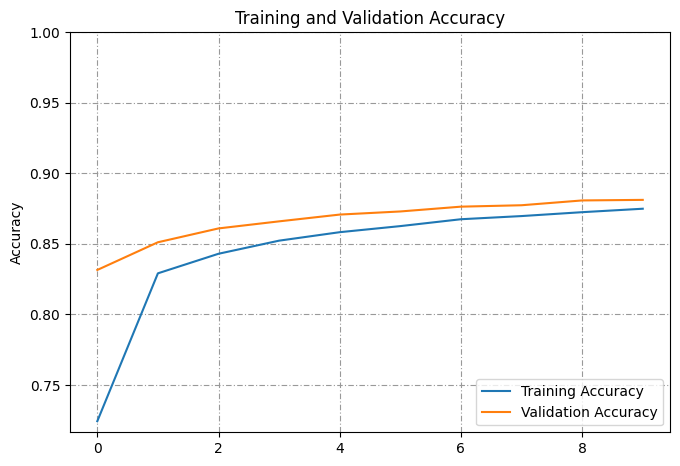

In [25]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig_1 = plt.figure(figsize=(6, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))

ax.plot(acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy')
ax.set_ylim([min(plt.ylim()),1])
ax.set_title('Training and Validation Accuracy')
plt.show()


In [16]:
loss, accuracy = model.evaluate(dataset_test)
print('Test accuracy :', accuracy)


312/312 [==============================] - 21s 66ms/step - loss: 0.3808 - accuracy: 0.8738
Test accuracy : 0.8737980723381042


In [17]:
model.save("cifar10Classifier.h5")

In [114]:
predictions = model.predict(x_test)
confusion_matrix = tf.math.confusion_matrix(y_test, predictions.argmax(axis=1))

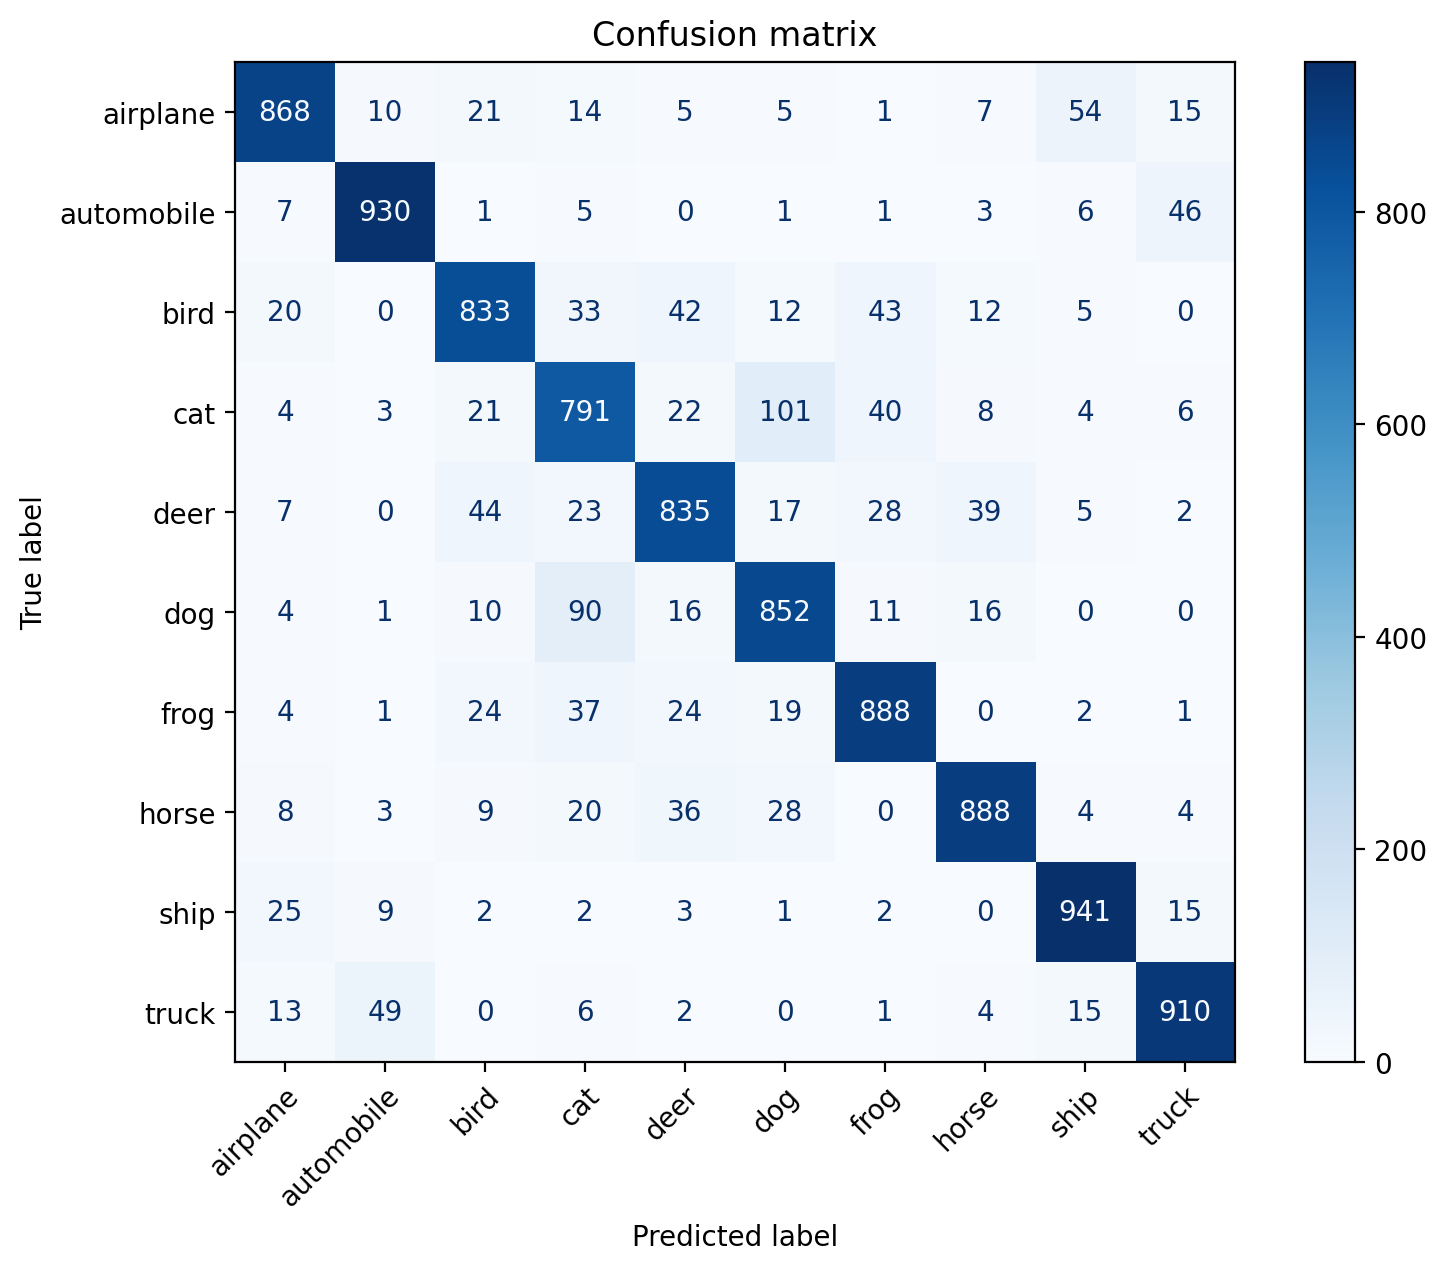

In [117]:
fig_1 = plt.figure(figsize=(7, 5), dpi=200)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_title("Confusion matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix.numpy(),
                              display_labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()

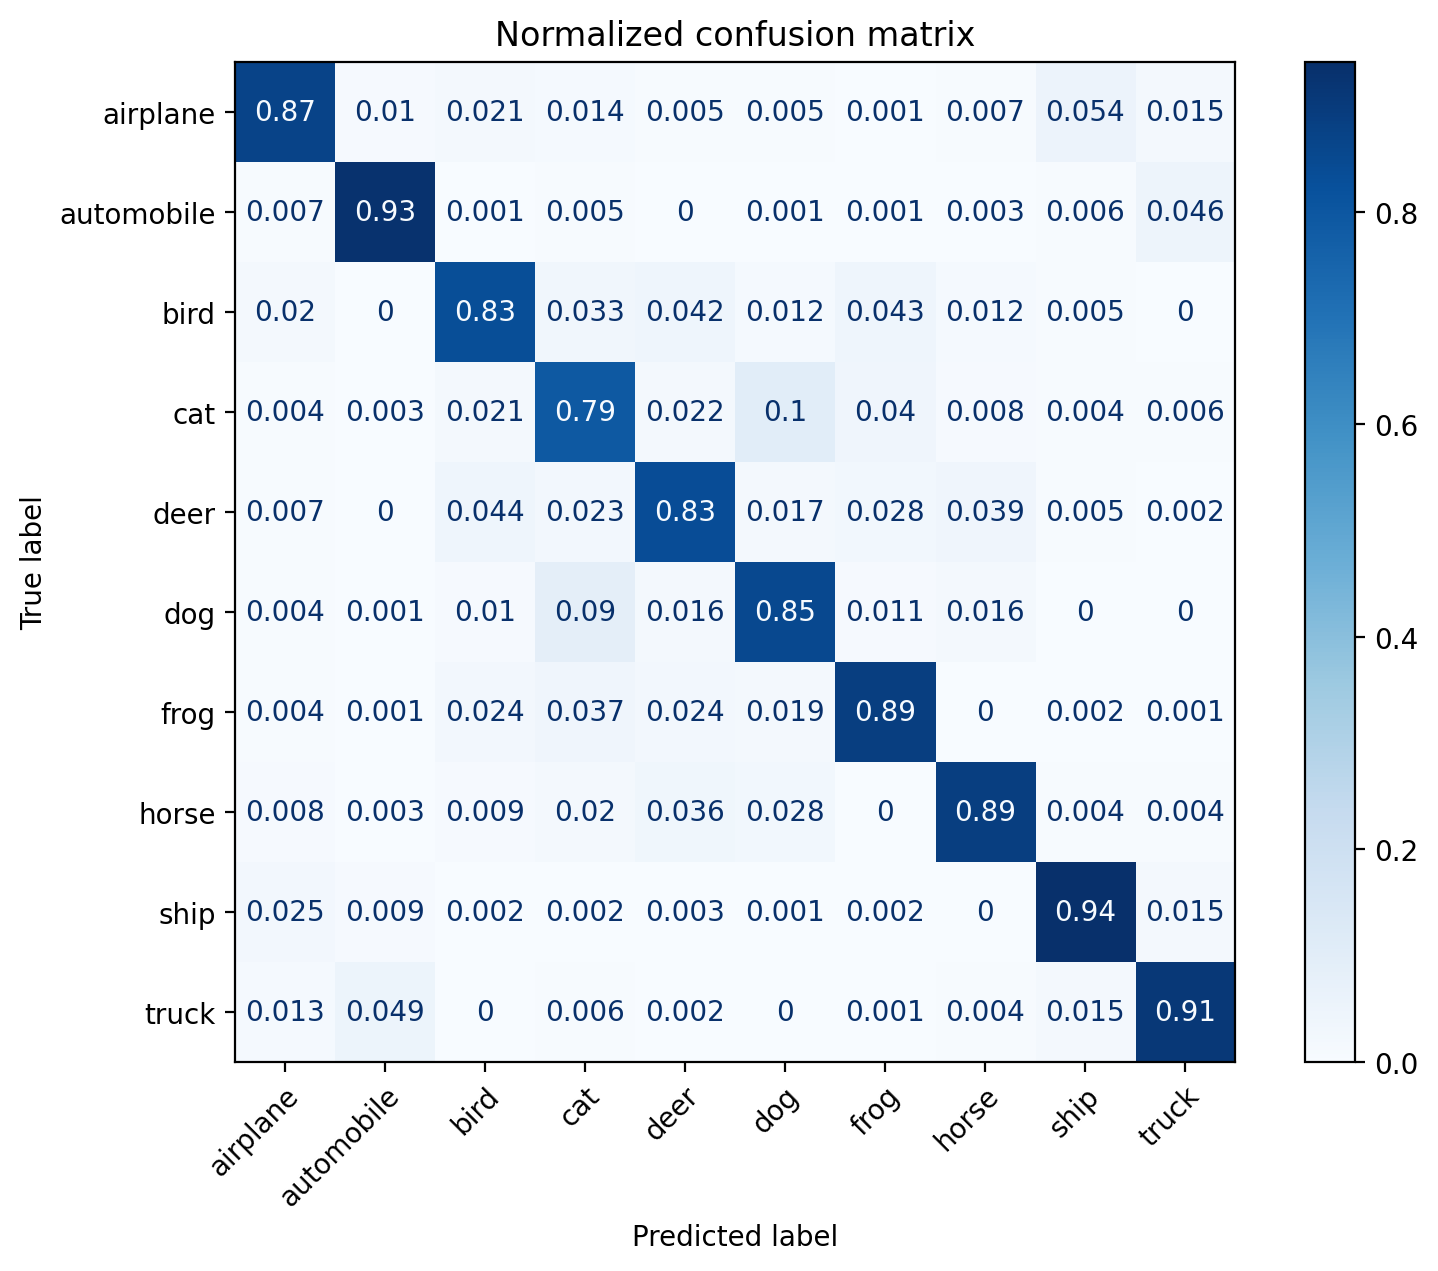

In [118]:
normed_c = confusion_matrix.numpy() / np.sum(confusion_matrix.numpy(), axis=1, keepdims=True)

fig_1 = plt.figure(figsize=(7, 5), dpi=200)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_title("Normalized confusion matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=normed_c,
                              display_labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()